# Some Preprocessing

Import the different libraries and the data
Transforming categorical feeature into dummies...

In [29]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif

plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)

dataset = pd.read_csv("../data/cleanData.csv")


In [30]:
dataset['support_type']

0       Strainer Original
1       Strainer Original
2       Strainer Original
3       Strainer Original
4       Strainer Original
              ...        
203    Stretcher Original
204     Strainer Original
205    Stretcher Original
206         Stretcher New
207    Stretcher Original
Name: support_type, Length: 208, dtype: object

We want to capture the features that have the greatest Mutual Information with the columns we want to predict.
But first we try to get dummy variables for every categorical feature we think can have an impact on our predictions.

In [31]:
dataset['ground_condition'] = dataset['ground_condition'].fillna('Condition Unspecified')
dataset['media_condition'] = dataset['media_condition'].fillna('Condition Unspecified')
dataset['auxiliary_support_condition'] = dataset['auxiliary_support_condition'].fillna('Condition Unspecified')

one_hot = pd.get_dummies(dataset['ground_layer_limit'])
MIData = dataset.drop('ground_layer_limit', axis=1)
MIData = MIData.join(one_hot)

one_hot = pd.get_dummies(dataset['ground_layer_application'])
MIData = MIData.drop('ground_layer_application', axis=1)
MIData = MIData.join(one_hot, lsuffix="limit", rsuffix="application")

one_hot = pd.get_dummies(dataset['ground_layer_thickness'])
MIData = MIData.drop('ground_layer_thickness', axis=1)
MIData = MIData.join(one_hot, rsuffix="thickness")

one_hot = pd.get_dummies(dataset['support_type'])
MIData = MIData.drop('support_type', axis=1)
MIData = MIData.join(one_hot, lsuffix="thickness", rsuffix="supptype")

one_hot = pd.get_dummies(dataset['media_type_1'])
MIData = MIData.drop('media_type_1', axis=1)
MIData = MIData.join(one_hot)

one_hot = pd.get_dummies(dataset['media_condition'])
MIData = MIData.drop('media_condition', axis=1)
MIData = MIData.join(one_hot)

one_hot = pd.get_dummies(dataset['auxiliary_support_condition'])
MIData = MIData.drop('auxiliary_support_condition', axis=1)
MIData = MIData.join(one_hot, lsuffix='media_cond', rsuffix="aux_cond")

one_hot = pd.get_dummies(dataset['frame_material'])
MIData = MIData.drop('frame_material', axis=1)
MIData = MIData.join(one_hot, lsuffix="mediaType", rsuffix="frameMat")

one_hot = pd.get_dummies(dataset['collection'])
MIData = MIData.drop('collection', axis=1)
MIData = MIData.join(one_hot)

one_hot = pd.get_dummies(dataset['ground_condition'])
MIData = MIData.drop('ground_condition', axis=1)
MIData = MIData.join(one_hot, lsuffix="other_cond", rsuffix="ground_cond")

one_hot = pd.get_dummies(dataset['canvas'])
MIData = MIData.drop('canvas', axis=1)
MIData = MIData.join(one_hot, rsuffix="canvas")

MIData.columns = MIData.columns.astype(str)

MIDataCateg = MIData.select_dtypes( exclude=["float64", "object"]) # Selecting only categorical data
#MIDataCateg = MIData.select_dtypes( include=["object"])
MIDataCateg = MIDataCateg.dropna()

miApp = mutual_info_classif(MIDataCateg, MIDataCateg["Artist Applied Ground"])
miLim = mutual_info_classif(MIDataCateg, MIDataCateg["To Face Edge"])
miThic = mutual_info_classif(MIDataCateg, MIDataCateg["Thinly Applied"])


The thickness of the ground layer and the limit of its application seem to have a correlation with the fact that the layer was applied by the artist or not. We will use these features and the others shown in the 

# Predicting `ground_layer_application`

## First splitting of the data

In [32]:
dataset['ground_condition'] = dataset['ground_condition'].fillna('Condition Unspecified')
colnames = ['ground_layer_application', 'ground_layer_limit', 'ground_layer_thickness', 'size_layer_visible', 'ground_condition',
            'coloured_ground', 'id_sulphate', 'id_carbonate', 'uniform_application', 'ground_proprietary_paint', 'collection']

One hot encode categorical data with more than two values

In [33]:
prediction_set = dataset[colnames]
one_hot = pd.get_dummies(prediction_set['ground_layer_limit'])
prediction_set = prediction_set.drop('ground_layer_limit', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_layer_thickness'])
prediction_set = prediction_set.drop('ground_layer_thickness', axis=1)
prediction_set = prediction_set.join(one_hot, lsuffix="limit", rsuffix="thickness")

one_hot = pd.get_dummies(prediction_set['collection'])
prediction_set = prediction_set.drop('collection', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_condition'])
prediction_set = prediction_set.drop('ground_condition', axis=1)
prediction_set = prediction_set.join(one_hot)
prediction_set.columns = prediction_set.columns.astype(str)

Split data into training, validation and testing set

In [34]:
prediction_set.ground_layer_application

0                Unspecified
1      Artist Applied Ground
2      Artist Applied Ground
3      Artist Applied Ground
4          Commercial Ground
               ...          
203        Commercial Ground
204        Commercial Ground
205        Commercial Ground
206        Commercial Ground
207    Artist Applied Ground
Name: ground_layer_application, Length: 208, dtype: object

In [35]:
X = prediction_set[(prediction_set['ground_layer_application'] != 'Unspecified') & (prediction_set['ground_layer_application'] != 'Unsure')]
test = prediction_set[(prediction_set['ground_layer_application'] == 'Unspecified') | (prediction_set['ground_layer_application'] == 'Unsure')]

In [36]:
y = X.ground_layer_application
X = X.drop('ground_layer_application', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=25)

In [37]:
y_train.name

'ground_layer_application'

In [38]:
X_test = test.drop('ground_layer_application', axis=1)

In [39]:
X_train.shape, X_valid.shape

((128, 23), (56, 23))

In [40]:
X_test.shape

(24, 23)

## Second splitting of the data

In [42]:
#Excluding the possible values for Gorund_layer_application
miApp = pd.Series(miApp)
miApp.index = MIDataCateg.columns
miApp = miApp.drop(labels=['Artist Applied Ground', 'Commercial Ground', 'Unspecifiedapplication', 'Unsure'])

ValueError: Length mismatch: Expected axis has 216 elements, new values have 220 elements

In [45]:
indexApp = miApp.sort_values(ascending=False)[0:20].index

datagApp = MIData[indexApp].join(dataset['ground_layer_application'])

Xbis = datagApp[(datagApp['ground_layer_application'] != 'Unspecified') & (datagApp['ground_layer_application'] != 'Unsure')]
testbis = datagApp[(datagApp['ground_layer_application'] == 'Unspecified') | (datagApp['ground_layer_application'] == 'Unsure')]

ybis = Xbis.ground_layer_application
Xbis = Xbis.drop('ground_layer_application', axis=1)
Xb_train, Xb_valid, yb_train, yb_valid = train_test_split(Xbis, ybis, test_size=0.3, random_state=25)

Xb_test = testbis.drop('ground_layer_application', axis=1)

## Baseline model: Bernoulli Naive Bayes

In [51]:
switch={
      'ground_layer_application':['Artist Applied', 'Commercial'],
      'ground_layer_limit':['To Face Edge', 'To Side Edge'],
      'ground_layer_thickness':['Thinly Applied', 'Thickly Applied'],
}
def NB_analysis(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    """
    Fit a Naive Bayes model, plot a confusion matrix and return the prediction for the unspecified data.
    """
    bnb = BernoulliNB()
    bnb.fit(Xtrain, ytrain)
    print("Training Accuracy:", bnb.score(Xtrain, ytrain))
    print("Holdout Accuracy:", bnb.score(Xvalid, yvalid))
     
    feature = ytrain.name

    valid_prediction = bnb.predict(Xvalid)
    cm = confusion_matrix(yvalid, valid_prediction)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized']),
            yticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized'])) 
    ax.set_xlabel('Predicted Label')    
    ax.set_ylabel('Actual Label')
    ax.set_title('Confusion Matrix for Bernoulli Naive Bayes')
    plt.show() 

    test_prediction = bnb.predict(Xtest)
    return(test_prediction)

Training Accuracy: 0.7890625
Holdout Accuracy: 0.7321428571428571


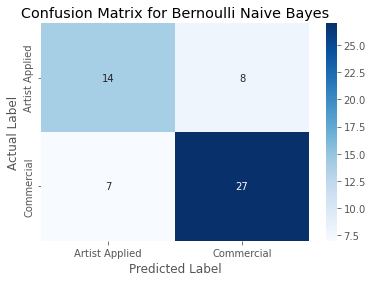

In [16]:
pred = NB_analysis(X_train, y_train, X_valid, y_valid, X_test)

Training Accuracy: 0.828125
Holdout Accuracy: 0.7142857142857143


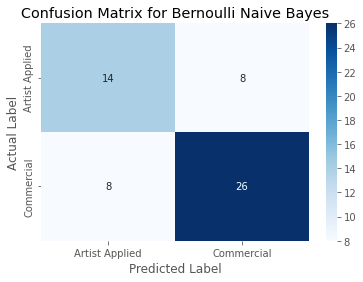

In [52]:
predbis = NB_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test)

In [18]:
print("Training data class distribution: ", Counter(y_train))
print("Validation data class distribution: ", Counter(y_valid))
print("Validation prediction distribution: ", Counter(pred))

Training data class distribution:  Counter({'Artist Applied Ground': 68, 'Commercial Ground': 60})
Validation data class distribution:  Counter({'Commercial Ground': 34, 'Artist Applied Ground': 22})
Validation prediction distribution:  Counter({'Commercial Ground': 18, 'Artist Applied Ground': 6})


Print predictions

In [19]:
print(pred)
print(predbis)

['Commercial Ground' 'Commercial Ground' 'Commercial Ground'
 'Commercial Ground' 'Commercial Ground' 'Commercial Ground'
 'Artist Applied Ground' 'Commercial Ground' 'Artist Applied Ground'
 'Commercial Ground' 'Commercial Ground' 'Commercial Ground'
 'Commercial Ground' 'Artist Applied Ground' 'Commercial Ground'
 'Artist Applied Ground' 'Artist Applied Ground' 'Commercial Ground'
 'Commercial Ground' 'Commercial Ground' 'Commercial Ground'
 'Commercial Ground' 'Artist Applied Ground' 'Commercial Ground']
['Commercial Ground' 'Commercial Ground' 'Commercial Ground'
 'Commercial Ground' 'Commercial Ground' 'Artist Applied Ground'
 'Artist Applied Ground' 'Commercial Ground' 'Artist Applied Ground'
 'Commercial Ground' 'Commercial Ground' 'Commercial Ground'
 'Commercial Ground' 'Artist Applied Ground' 'Commercial Ground'
 'Artist Applied Ground' 'Artist Applied Ground' 'Commercial Ground'
 'Commercial Ground' 'Artist Applied Ground' 'Artist Applied Ground'
 'Commercial Ground' 'Commer

## Support Vector Machine

Without hyperparameter tuning

In [20]:
def SVM_analysis(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    """
    Fit a Support Vector model, plot a confusion matrix and return the prediction for the unspecified data.
    """
    param_range = np.logspace(-2, 2, 30)

    train_score, validation_scores = validation_curve(
    SVC(), Xtrain.append(Xvalid), ytrain.append(yvalid), param_name='C', cv=5,
    param_range=param_range, n_jobs=-1, verbose=-1
    )
    mean_valid_score = np.mean(validation_scores, axis=1)
    bestparam = param_range[mean_valid_score.argmax()]

    svm = SVC(C=bestparam)
    svm.fit(Xtrain, ytrain)
    print("Training Accuracy:", svm.score(Xtrain, ytrain))
    print("Holdout Accuracy:", svm.score(Xvalid, yvalid))

    valid_prediction = svm.predict(Xvalid)
    feature = ytrain.name
    cm = confusion_matrix(yvalid, valid_prediction)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
        xticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized']),
        yticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized'])) 
    ax.set_xlabel('Predicted Label')    
    ax.set_ylabel('Actual Label')
    ax.set_title('Confusion Matrix for Support Vector Classifier')
    plt.show() 

    test_prediction = svm.predict(Xtest)
    return(test_prediction)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:   10.6s remaining: 13.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.1s finished


Training Accuracy: 0.890625
Holdout Accuracy: 0.8035714285714286


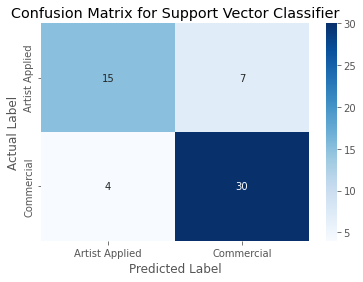

In [21]:
pred = SVM_analysis(X_train, y_train, X_valid, y_valid, X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:    0.2s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished


Training Accuracy: 0.8203125
Holdout Accuracy: 0.7678571428571429


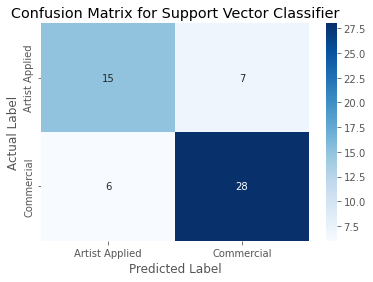

In [22]:
predbis = SVM_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test)

### Old Hyperparameter tuning with cross validation

In [23]:
param_range = np.logspace(-2, 2, 30)
train_score, validation_scores = validation_curve(
        SVC(), X, y, param_name='C', cv=5,
        param_range=param_range, n_jobs=-1, verbose=-1
        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:    0.2s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished


In [24]:
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_valid_score = np.mean(validation_scores, axis=1)
std_valid_score = np.std(validation_scores, axis=1)

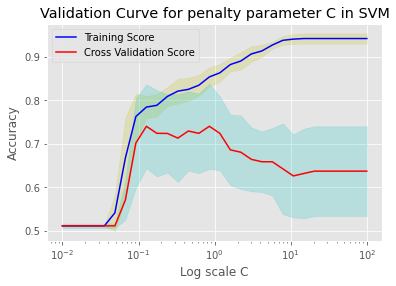

In [25]:
plt.semilogx(param_range, mean_train_score, label='Training Score', color='b')
plt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='y')
plt.semilogx(param_range, mean_valid_score, label='Cross Validation Score', color='r')
plt.fill_between(param_range, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='c')
plt.legend(loc='best')
plt.title('Validation Curve for penalty parameter C in SVM')
plt.xlabel('Log scale C')
plt.ylabel('Accuracy')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:    0.2s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished


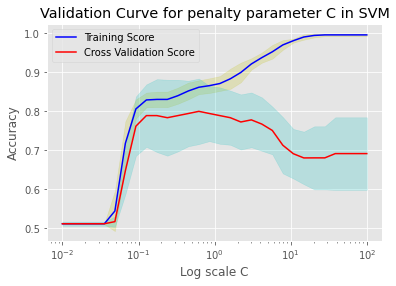

In [26]:
train_score_bis, validation_scores_bis = validation_curve(
    SVC(), Xbis, ybis, param_name='C', cv=5,
    param_range=param_range, n_jobs=-1, verbose=-1
)
mean_train_score_bis = np.mean(train_score_bis, axis=1)
std_train_score_bis = np.std(train_score_bis, axis=1)
mean_valid_score_bis = np.mean(validation_scores_bis, axis=1)
std_valid_score_bis = np.std(validation_scores_bis, axis=1)

plt.semilogx(param_range, mean_train_score_bis, label='Training Score', color='b')
plt.fill_between(param_range, mean_train_score_bis - std_train_score_bis, mean_train_score_bis + std_train_score_bis, alpha=0.2, color='y')
plt.semilogx(param_range, mean_valid_score_bis, label='Cross Validation Score', color='r')
plt.fill_between(param_range, mean_valid_score_bis - std_valid_score_bis, mean_valid_score_bis + std_valid_score_bis, alpha=0.2, color='c')
plt.legend(loc='best')
plt.title('Validation Curve for penalty parameter C in SVM')
plt.xlabel('Log scale C')
plt.ylabel('Accuracy')
plt.show()

In [27]:
best_c_value_bis = param_range[mean_valid_score_bis.argmax()]
best_c_value_bis

0.6210169418915616

Evaluation using confusion matrix

## Random forest classifier

In [28]:
def RF_analysis(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    """
    Fit a Random Forest classifier, plot a confusion matrix and return the prediction for the unspecified data.
    """
    param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
    }
    rfc=RandomForestClassifier(random_state=42)
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(Xtrain.append(Xvalid), ytrain.append(yvalid))   
    bestparam=CV_rfc.best_params_
    #Add also a n_estimator exploration step Gridsearch for both estimators and max_depth

    #mean_valid_score = np.mean(validation_scores, axis=1)
    #bestparam = param_range[mean_valid_score.argmax()]

    rfc = RandomForestClassifier(max_depth=bestparam['max_depth'], n_estimators=bestparam['n_estimators'],
     criterion =bestparam['criterion'], max_features=bestparam['max_features'] , random_state=10)
    rfc.fit(Xtrain, ytrain)
    print("Training Accuracy:", rfc.score(Xtrain, ytrain))
    print("Holdout Accuracy:", rfc.score(Xvalid, yvalid))

    valid_prediction = rfc.predict(Xvalid)
    cm = confusion_matrix(yvalid, valid_prediction)
    feature=ytrain.name

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
        xticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized']),
        yticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized'])) 
    ax.set_xlabel('Predicted Label')    
    ax.set_ylabel('Actual Label')
    ax.set_title('Confusion Matrix for Random Forest Classifier')
    plt.show() 

    test_prediction = rfc.predict(Xtest)
    return(test_prediction)

Training Accuracy: 0.8125
Holdout Accuracy: 0.7321428571428571


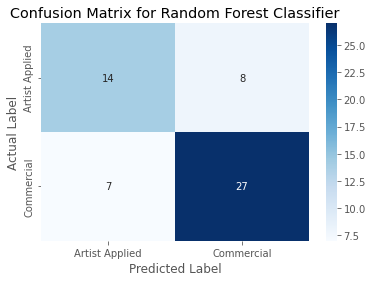

In [29]:
pred = RF_analysis(X_train, y_train, X_valid, y_valid, X_test)

Training Accuracy: 1.0
Holdout Accuracy: 0.75


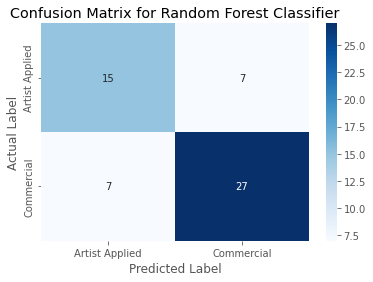

In [30]:
predbis = RF_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test)

### old Hyperparameter tuning for tree depth

In [31]:
"""param_range = np.arange(2, 20)
train_score, validation_scores = validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=10), X, y, param_name='max_depth', cv=5,
    param_range=param_range, n_jobs=-1, verbose=-1
)
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_valid_score = np.mean(validation_scores, axis=1)
std_valid_score = np.std(validation_scores, axis=1)
plt.semilogx(param_range, mean_train_score, label='Training Score', color='b')
plt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='y')
plt.semilogx(param_range, mean_valid_score, label='Cross Validation Score', color='r')
plt.fill_between(param_range, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='c')
plt.legend(loc='best')
plt.title('Validation Curve for Maximum Depth in RandomForestClassifier')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.show()"""

"param_range = np.arange(2, 20)\ntrain_score, validation_scores = validation_curve(\n    RandomForestClassifier(n_estimators=100, random_state=10), X, y, param_name='max_depth', cv=5,\n    param_range=param_range, n_jobs=-1, verbose=-1\n)\nmean_train_score = np.mean(train_score, axis=1)\nstd_train_score = np.std(train_score, axis=1)\nmean_valid_score = np.mean(validation_scores, axis=1)\nstd_valid_score = np.std(validation_scores, axis=1)\nplt.semilogx(param_range, mean_train_score, label='Training Score', color='b')\nplt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='y')\nplt.semilogx(param_range, mean_valid_score, label='Cross Validation Score', color='r')\nplt.fill_between(param_range, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='c')\nplt.legend(loc='best')\nplt.title('Validation Curve for Maximum Depth in RandomForestClassifier')\nplt.xlabel('Maximum Depth')\nplt.ylabel

## Logistic regression

In [53]:
def LR_analysis(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    """
    Fit a logistic regressor, plot a confusion matrix and return the prediction for the unspecified data.
    """
    param_range = np.logspace(-2, 2, 30)

    train_score, validation_scores = validation_curve(
    LogisticRegression(), Xtrain.append(Xvalid), ytrain.append(yvalid), param_name='C', cv=5,
    param_range=param_range, n_jobs=-1, verbose=-1
    )
    mean_valid_score = np.mean(validation_scores, axis=1)
    bestparam = param_range[mean_valid_score.argmax()]

    lr = LogisticRegression(C=bestparam)
    lr.fit(Xtrain, ytrain)
    print("Training Accuracy:", lr.score(Xtrain, ytrain))
    print("Holdout Accuracy:", lr.score(Xvalid, yvalid))

    valid_prediction = lr.predict(Xvalid)
    cm = confusion_matrix(yvalid, valid_prediction)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
        xticklabels = ['Artist Applied', 'Commercial'],
        yticklabels = ['Artist Applied', 'Commercial']) 
    ax.set_xlabel('Predicted Label')    
    ax.set_ylabel('Actual Label')
    ax.set_title('Confusion Matrix for Logistic regressor')
    plt.show() 

    test_prediction = lr.predict(Xtest)
    return(test_prediction)
# Look at usual C values

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:   18.0s remaining: 22.2min
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Training Accuracy: 0.7890625
Holdout Accuracy: 0.7142857142857143


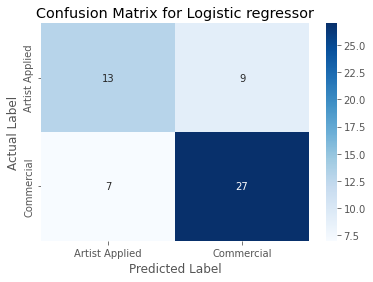

In [33]:
predLR = LR_analysis(X_train, y_train, X_valid, y_valid, X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:   12.0s remaining: 14.8min
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Training Accuracy: 0.8125
Holdout Accuracy: 0.6964285714285714


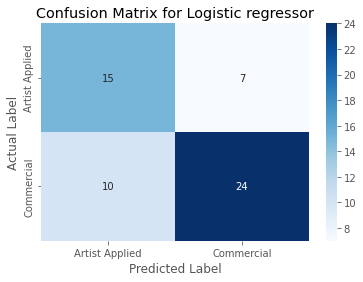

In [54]:
predbLR = LR_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test)

## Stacking

In [35]:
estimators = [
    ('BNB', BernoulliNB()),
    ('Logistic', LogisticRegression(C=0.8, max_iter=1000)),
    ('SVC', SVC(C=0.126896)),
    ('RF', RandomForestClassifier(max_depth=3, n_estimators=100,random_state=10 )), 
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=1000)
)

clf.fit(X_train, y_train)
valid_prediction = clf.predict(X_valid)
test_prediction = clf.predict(X_test)
print('Stacking Training Accuracy:', clf.score(X_train, y_train))
print('Stacking Validation Accuracy:', clf.score(X_valid, y_valid))

Stacking Training Accuracy: 0.796875
Stacking Validation Accuracy: 0.7321428571428571


In [36]:
estimatorsb = [
    ('BNB', BernoulliNB()),
    ('Logistic', LogisticRegression(C=1, max_iter=1000)),
    ('SVC', SVC(C=0.2395026619987486)),
    ('RF', RandomForestClassifier(max_depth=12, n_estimators=100, random_state=10)), 
]

clfb = StackingClassifier(
    estimators=estimatorsb, final_estimator=LogisticRegression(max_iter=1000)
)

clfb.fit(Xb_train, yb_train)
valid_predictionb = clfb.predict(Xb_valid)
#test_prediction = clf.predict(X_test)
print('Stacking Training Accuracy:', clfb.score(Xb_train, yb_train))
print('Stacking Validation Accuracy:', clfb.score(Xb_valid, yb_valid))

Stacking Training Accuracy: 0.8984375
Stacking Validation Accuracy: 0.8035714285714286


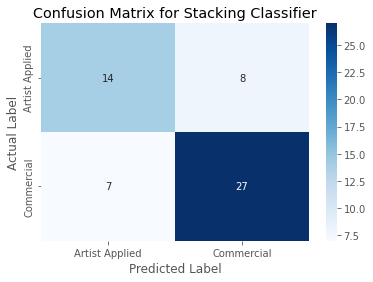

In [37]:
cm = confusion_matrix(y_valid, valid_prediction)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = ['Artist Applied', 'Commercial'],
            yticklabels = ['Artist Applied', 'Commercial'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix for Stacking Classifier')
plt.show()

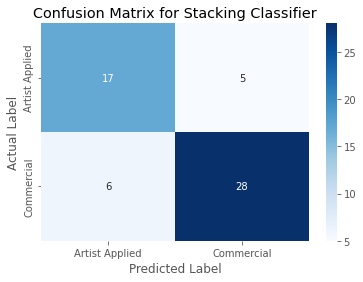

In [38]:
cmb = confusion_matrix(yb_valid, valid_predictionb)

ax = plt.subplot()
sns.heatmap(cmb, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = ['Artist Applied', 'Commercial'],
            yticklabels = ['Artist Applied', 'Commercial'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix for Stacking Classifier')
plt.show()

# Predicting for `ground_layer_limit`

## Splitting the data

In [46]:
#Excluding the possible values for Gorund_layer_application
miLim = pd.Series(miLim)
miLim.index = MIDataCateg.columns
miLim = miLim.drop(labels=['To Face Edge', 'To Side Edge', 'Unspecifiedlimit'])

In [47]:
indexLim = miLim.sort_values(ascending=False)[0:20].index

datagLim = MIData[indexLim].join(dataset['ground_layer_limit'])

Xlim = datagLim[(datagLim['ground_layer_limit'] != 'Unspecified')]
testlim = datagLim[(datagLim['ground_layer_limit'] == 'Unspecified')]

ylim = Xlim.ground_layer_limit
Xlim = Xlim.drop('ground_layer_limit', axis=1)
Xlim_train, Xlim_valid, ylim_train, ylim_valid = train_test_split(Xlim, ylim, test_size=0.3, random_state=25)

Xlim_test = testlim.drop('ground_layer_limit', axis=1)

## Naive Bayes

Training Accuracy: 0.7901234567901234
Holdout Accuracy: 0.9166666666666666


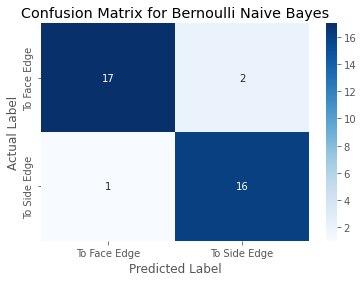

In [55]:
predlimNB = NB_analysis(Xlim_train, ylim_train, Xlim_valid, ylim_valid, Xlim_test)

## SVM

In [56]:
predlimSVM = SVM_analysis(Xlim_train, ylim_train, Xlim_valid, ylim_valid, Xlim_test)

NameError: name 'SVM_analysis' is not defined

## RF

/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Training Accuracy: 0.9506172839506173
Holdout Accuracy: 0.9444444444444444


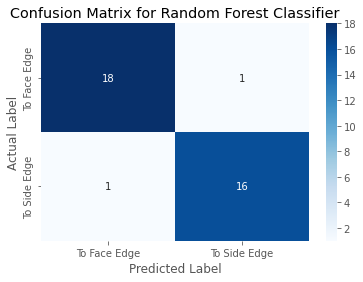

In [43]:
predlimRF = RF_analysis(Xlim_train, ylim_train, Xlim_valid, ylim_valid, Xlim_test)

## Logistic Regression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

Training Accuracy: 0.8641975308641975
Holdout Accuracy: 0.9444444444444444


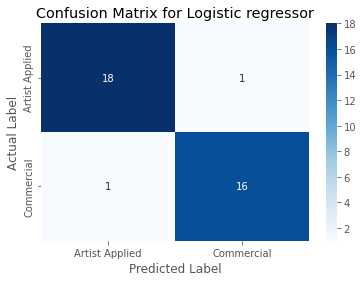

In [57]:
predlimLR = LR_analysis(Xlim_train, ylim_train, Xlim_valid, ylim_valid, Xlim_test)

## Stacking

# Predicting for `ground_layer_thickness`

## Splitting the data

In [48]:
#Excluding the possible values for Gorund_layer_application
miThic = pd.Series(miThic)
miThic.index = MIDataCateg.columns
miThic = miThic.drop(labels=['Thinly Applied', 'Thickly Applied', 'Unspecifiedthickness'])

In [49]:
indexThic = miThic.sort_values(ascending=False)[0:20].index

datagThic = MIData[indexThic].join(dataset['ground_layer_thickness'])

Xthic = datagThic[(datagThic['ground_layer_thickness'] != 'Unspecified')]
testthic = datagThic[(datagThic['ground_layer_thickness'] == 'Unspecified')]

ythic = Xthic.ground_layer_thickness
Xthic = Xthic.drop('ground_layer_thickness', axis=1)
Xthic_train, Xthic_valid, ythic_train, ythic_valid = train_test_split(Xthic, ythic, test_size=0.3, random_state=25)

Xthic_test = testthic.drop('ground_layer_thickness', axis=1)

## Naive Bayes

Training Accuracy: 0.6853932584269663
Holdout Accuracy: 0.6666666666666666


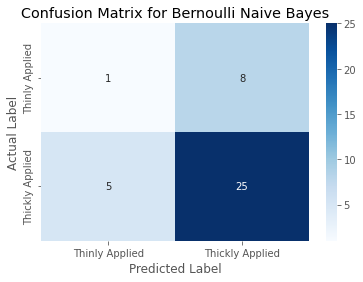

In [58]:
predthicNB = NB_analysis(Xthic_train, ythic_train, Xthic_valid, ythic_valid, Xthic_test)

## SVM

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:    0.2s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.8s finished


Training Accuracy: 0.7191011235955056
Holdout Accuracy: 0.7692307692307693


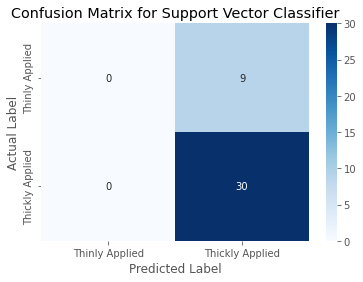

In [48]:
predthicSVM = SVM_analysis(Xthic_train, ythic_train, Xthic_valid, ythic_valid, Xthic_test)

## RF

/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Training Accuracy: 0.8202247191011236
Holdout Accuracy: 0.8205128205128205


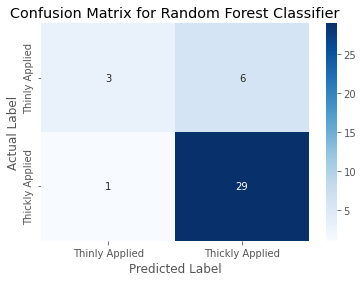

In [49]:
predthicSVM = RF_analysis(Xthic_train, ythic_train, Xthic_valid, ythic_valid, Xthic_test)

## LR

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
[Parallel(n_jobs=-1)]: Done   2 out of  66 | elapsed:    0.1s remaining:    3.5s
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: Conve

Training Accuracy: 0.7191011235955056
Holdout Accuracy: 0.7692307692307693


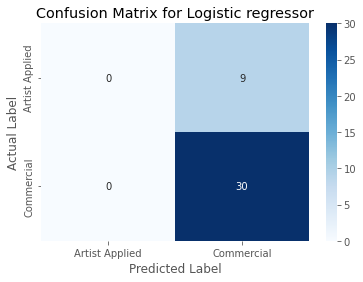

In [59]:
predthicSVM = LR_analysis(Xthic_train, ythic_train, Xthic_valid, ythic_valid, Xthic_test)